In [1]:
import bias

import numpy as nd
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor  # HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ----- Configuration Variables -----

NUMERIC_FEATURES = ["year", "author_seniority", "num_aggl_publications"]
#CATEGORIAL_FEATURES = ["author_gender", "author_country", "author_classification", "author_journal_classification", "author_continent"]
CATEGORIAL_FEATURES = ["author_gender", "author_classification_cluster", "author_journal_classification", "author_continent"] # classification erstmal nicht als feature betrachten
SAMPLING_COLUMN = "num_aggl_publications_cluster"      # name of the feature / column that is used to sample the test data into equally sized data sets
TARGET_FEATURE = "num_aggl_single_publications" # name of the feature / clumn that will be predicted
NUM_FOLDS = 10
RANDOM_STATE = 1

#MODEL = HistGradientBoostingRegressor(max_depth=6, max_leaf_nodes=64)
MODEL = GradientBoostingRegressor(n_estimators=140, min_samples_leaf=5, max_depth=15)

# -----------------------------------

FEATURE_PREPROCESSOR = ColumnTransformer(
    n_jobs=3,
    transformers=[
        ('num',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                #('scaler', StandardScaler())
            ]), NUMERIC_FEATURES),
        ('cat', OneHotEncoder(), CATEGORIAL_FEATURES)  # OneHotEncoder(drop="first")
    ])

## Data import and preprocessing

In [2]:
data = bias.preprocess_dataset("zbmath_simple_collaboration_model_1970-2019.csv",
        categorial_rows=CATEGORIAL_FEATURES + ["author_classification"],
        drop_rows=["author_id", "num_aggl_collaborations", "num_aggl_collaborators"])
        # author_classification: erstmal nicht als feature betrachtet (ansonsten zu viele)
        # num_aggl_single_publications: abhängig von Gesamtanzahl an Publikationen

# Cluster num_aggl_publications and author_classification columns
data = bias.cluster_column(data, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
data = bias.cluster_column(data, bias.EGONET_1_CLUSTERING, "author_classification", newcolumn="author_classification_cluster")
data = data.loc[data.year>=1970]
data.sample(10)

year author_gender author_country  author_seniority  \
1684379  1997             m          Other                 4   
1591328  1976             m          Other                11   
32973    2008             u             RU                 0   
2197300  2012             f          Other                 0   
2572288  1981             m          Other                 5   
921793   2015             m             HU                30   
2742560  1997             m             TR                10   
2313433  2016             m             IT                 2   
2625979  1974             m          Other                 6   
2387514  1991             m             JP                22   

        author_classification author_journal_classification  \
1684379                    14                         KAT 1   
1591328                    55                         KAT 2   
32973                      33                         KAT 1   
2197300                    65                         KAT 3   
2572288                    40                         KAT 1   
921793                     51                    FAST TRACK   
2742560                    55                         KAT 9   
2313433                    14                         KAT 1   
2625979                    46                    FAST TRACK   
2387514                    47                         KAT 1   

         num_aggl_publications  num_aggl_single_publications author_continent  \
1684379                      1                             1                    
1591328                     11                            11               AS   
32973                        2                             2               EU   
2197300                      2                             0                    
2572288                      7                             6                    
921793                      16                            11               EU   
2742560                      4                             0               AS   
2313433                      2                             2               EU   
2625979                      1                             1                    
2387514                     50                            14               AS   

        num_aggl_publications_cluster         author_classification_cluster  
1684379                          a) 1    Number theory / Algebraic geometry  
1591328                      i) 11-13  Category theory / Algebraic topology  
32973                            b) 2              Real & complex functions  
2197300                          b) 2             PDE / Numerical / Physics  
2572288                        g) 7-8        Topology / Functional analysis  
921793                       j) 14-18                              Geometry  
2742560                          d) 4  Category theory / Algebraic topology  
2313433                          b) 2    Number theory / Algebraic geometry  
2625979                          a) 1        Topology / Functional analysis  
2387514                      l) 30-50        Topology / Functional analysis

## Sampling

In [3]:
dataset = data.reset_index(drop=True) # incremental reindexing to fill index-gaps

# split / select & sample data into two equal sized _final datasets (size is determined by the SAMPLING_COLUMN)
male_all = dataset[dataset.author_gender == "m"]
female_final = dataset[dataset.author_gender == "f"]

_, male_final = bias.sampled_train_test_split(male_all, female_final, SAMPLING_COLUMN, random_state=RANDOM_STATE)

a) 1
b) 2
c) 3
d) 4
e) 5
f) 6
g) 7-8
h) 9-10
i) 11-13
j) 14-18
k) 19-29
l) 30-50
m) >50


## Generate 'normal' and 'switched' data sets

In [4]:
female_final = female_final.drop("num_aggl_publications_cluster", axis=1)
female_final_switched = female_final.copy()
female_final_switched["author_gender"] = "m"

male_final = male_final.drop("num_aggl_publications_cluster", axis=1)
male_final_switched = male_final.copy()
male_final_switched["author_gender"] = "f"

In [5]:
dataset_equal_sample_sizes = pd.concat([female_final, male_final], ignore_index=True)
dataset_equal_sample_sizes_switched = pd.concat([female_final_switched, male_final_switched], ignore_index=True)

In [6]:
print(len(dataset_equal_sample_sizes))
print(len(dataset_equal_sample_sizes_switched))

602398
602398


In [7]:
X, y = bias.X_y_split(dataset_equal_sample_sizes, TARGET_FEATURE)
X_switched, y_switched = bias.X_y_split(dataset_equal_sample_sizes_switched, TARGET_FEATURE)

In [8]:
X_t = FEATURE_PREPROCESSOR.fit_transform(X)
X_switched_t = FEATURE_PREPROCESSOR.transform(X_switched)

feature_names = NUMERIC_FEATURES+list(FEATURE_PREPROCESSOR.transformers_[1][1].get_feature_names())

In [9]:
Df = pd.DataFrame
if FEATURE_PREPROCESSOR.sparse_output_:
    Df = pd.DataFrame.sparse.from_spmatrix

X_t = Df(X_t, columns=feature_names, index=X.index)
X_switched_t = Df(X_switched_t, columns=feature_names, index=X_switched.index)

## Train & evaluate model

In [10]:
fold_results, feature_importance, switched_fold_results = bias.gs_k_fold_eval(
    MODEL,
    NUM_FOLDS,
    X_t,
    y,
    copy=["year", "x0_f", "x0_m", "author_seniority", "num_aggl_publications"],
    feature_names=feature_names,
    random_state=RANDOM_STATE,
    test_only=[(X_switched_t, y_switched)])

Working on fold 1
Working on fold 2
Working on fold 3
Working on fold 4
Working on fold 5
Working on fold 6
Working on fold 7
Working on fold 8
Working on fold 9
Working on fold 10


## Feature importance in trained models

In [11]:
from statistics import mean
for fi in sorted(feature_importance.items(), key=lambda f: mean(f[1]), reverse=True): print(fi)

('num_aggl_publications', [0.6422111113805231, 0.646587740197175, 0.6330886523596478, 0.6475015240380325, 0.6500278958277369, 0.6448966292442605, 0.6454128517354235, 0.6452076759893857, 0.6336950626780853, 0.6449524160680286])
('year', [0.10413956450555144, 0.10261554819703636, 0.1067972245762386, 0.0995205301685542, 0.10052352959982877, 0.1011606222759297, 0.10239142525658633, 0.09875332994500982, 0.10381996219302309, 0.10163889088574228])
('author_seniority', [0.0863513040411551, 0.08660577994794579, 0.08890646503869758, 0.0877898788717667, 0.085745106255883, 0.08783267606864625, 0.08635096973638966, 0.08912403648087527, 0.09214208263144856, 0.08805974778430567])
('x3_EU', [0.011413485080274286, 0.011520019379850461, 0.011573781118589246, 0.011552295108098815, 0.011208221727776722, 0.011506380695686623, 0.01142622012599339, 0.011124233615184468, 0.011181078516279096, 0.011345070817823058])
('x2_KAT 1', [0.011669626092014376, 0.010137815545526953, 0.011640342941268138, 0.0105365963962

In [12]:
# Add percentage of single_authored_papers to results
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    r_test["y_hat_perc"] = (r_test["y_hat"] * 100) / r_test["num_aggl_publications"]
    r_switched_test["y_hat_perc"] = (r_switched_test["y_hat"] * 100) / r_switched_test["num_aggl_publications"]
    r_test["y_perc"] = (r_test["y"] * 100) / r_test["num_aggl_publications"]
    r_switched_test["y_perc"] = (r_switched_test["y"] * 100) / r_switched_test["num_aggl_publications"]

# combine all results for plotting
r_test_all = pd.concat([r[1] for r in fold_results], ignore_index=True)
r_test_all = bias.cluster_column(r_test_all, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
r_switched_test_all = pd.concat(switched_fold_results, ignore_index=True)
r_switched_test_all = bias.cluster_column(r_switched_test_all, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")

In [29]:
# Wasserstein-distances for combined results
from scipy.stats import wasserstein_distance


print("WD (F, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_f"]==1]["y_hat"], r_switched_test_all[r_test_all["x0_f"]==1]["y_hat"])))
print("WD (F, S(M)=F):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_f"]==1]["y_hat"], r_switched_test_all[r_test_all["x0_m"]==1]["y_hat"])))
print("WD (M, S(M)=F):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_m"]==1]["y_hat"], r_switched_test_all[r_test_all["x0_m"]==1]["y_hat"])))
print("WD (M, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_m"]==1]["y_hat"], r_switched_test_all[r_test_all["x0_f"]==1]["y_hat"])))

#print("WD (F, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_f"]==1]["y_hat_perc"], r_switched_test_all[r_test_all["x0_f"]==1]["y_hat_perc"])))
#print("WD (F, S(M)=F):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_f"]==1]["y_hat_perc"], r_switched_test_all[r_test_all["x0_m"]==1]["y_hat_perc"])))
#print("WD (M, S(M)=F):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_m"]==1]["y_hat_perc"], r_switched_test_all[r_test_all["x0_m"]==1]["y_hat_perc"])))
#print("WD (M, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_m"]==1]["y_hat_perc"], r_switched_test_all[r_test_all["x0_f"]==1]["y_hat_perc"])))

WD (F, S(F)=M):	0.5784259086891962
WD (F, S(M)=F):	0.8426246765550116
WD (M, S(M)=F):	0.5435738530563847
WD (M, S(F)=M):	0.8097073210727675


In [43]:
print("WD (F, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_f"]==1]["y_hat"], r_test_all[r_test_all["x0_f"]==1]["y_hat"]-.2)))

WD (F, S(F)=M):	0.2


## Comparison of model prediction metrics

In [51]:
import numpy as np
x = np.random.normal(loc=0.2, scale=0.1, size=len(r_test_all[r_test_all["x0_m"]==1]["y_hat"]))

print("WD (F, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_m"]==1]["y_hat"], r_test_all[r_test_all["x0_m"] == 1]["y_hat"] +x)))

WD (F, S(F)=M):	0.19984023432997858


In [49]:
len(x)

301199

In [14]:
import importlib
importlib.reload(bias)
for i in range(len(fold_results)):
    print("Fold: ", i)
    r_train, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    print("Train (normal dataset only)")
    print(bias.stringify_gs_train_result(r_train))
    print("Test (left: normal dataset, right: switched dataset)")
    print(bias.compare_gs_results(r_test, r_switched_test))

Fold:  0
Train (normal dataset only)
Size:	542158
Size F:	271281
Size M:	270877
R2:	0.8779821493943638
R2 F:	0.8798841156789987
R2 M:	0.8756428350779597
MAE:	1.5256607562599098
MAE F:	1.3503504649377174
MAE M:	1.701232514438624
Mean y:	4.06738072665164
Mean y F:	3.371673652043453
Mean y M:	4.764125414856189
Mean y_hat:	4.067380726651589
Mean y_hat F:	3.3737847550343663
Mean y_hat M:	4.762011163256708

Test (left: normal dataset, right: switched dataset)
Size:	60240		60240
Size F:	29918		30322
Size M:	30322		29918
R2:	0.6944734772801586	0.6075266758192299
R2 F:	0.7849438406007843	0.5912128093648417
R2 M:	0.6397907266388214	0.6272274076578146
MAE:	2.0130137914848905	2.2652129750499843
MAE F:	1.671854438496155	2.4447058514290583
MAE M:	2.3496276534569565	2.0832963028938813
Mean y F:	3.2980145731666557	4.712123210869995
Mean y M:	4.712123210869995	3.2980145731666557
Mean y_hat F:	3.3306976680530407	4.171325263758356
Mean y_hat M:	4.720540151416508	3.8955379908013876
WD (F, S(F)=M):	0.57598

Size:	60240		60240
Size F:	30305		29935
Size M:	29935		30305
R2:	0.682356594225292	0.6021874326900365
R2 F:	0.7910083592268099	0.5882863390051098
R2 M:	0.618267155717318	0.6181639199996376
MAE:	2.0276670099204135	2.281769473461644
MAE F:	1.668453887907991	2.4761297219036793
MAE M:	2.3913200469201286	2.089782209409101
Mean y F:	3.343903646262993	4.758042425254718
Mean y M:	4.758042425254718	3.343903646262993
Mean y_hat F:	3.347515423322308	4.201718034423373
Mean y_hat M:	4.764329291863684	3.9271667699282977
WD (F, S(F)=M):	0.5837957493429173
WD (F, S(M)=F):	0.8679458880991906
WD (M, S(M)=F):	0.5627173020819173
WD (M, S(F)=M):	0.8380667747302817


Fold:  8
Train (normal dataset only)
Size:	542159
Size F:	271213
Size M:	270946
R2:	0.8765565439509408
R2 F:	0.8780174741997469
R2 M:	0.87433634078532
MAE:	1.5282212156849497
MAE F:	1.3517230484744875
MAE M:	1.7048933105808002
Mean y:	4.054812333651198
Mean y F:	3.3563951580492084
Mean y M:	4.753917754829375
Mean y_hat:	4.054812333651257
Mean y

In [36]:
from scipy.stats import wasserstein_distance

print("Gender difference in data", wasserstein_distance(r_test_all[r_test_all["x0_f"] == 1]["y"], r_test_all[r_test_all["x0_m"] == 1]["y"]))
print("Gender difference in switched data", wasserstein_distance(r_switched_test_all[r_test_all["x0_f"] == 1]["y"], r_switched_test_all[r_test_all["x0_m"] == 1]["y"]))

print("Female", r_test_all[r_test_all["x0_f"] == 1]["y_hat_perc"].mean())
print("Male", r_test_all[r_test_all["x0_m"] == 1]["y_hat_perc"].mean())

print("Female switched", r_switched_test_all[r_switched_test_all["x0_f"] == 1]["y_hat_perc"].mean())
print("Male switched", r_switched_test_all[r_switched_test_all["x0_m"] == 1]["y_hat_perc"].mean())

Gender difference in data 1.3945331823811076
Gender difference in switched data 1.3945331823811076
Female 30.623362138225982
Male 41.91749865835973
Female switched 37.74647084784524
Male switched 35.280179444664206


## Graphical distibution of predictions by document publication year

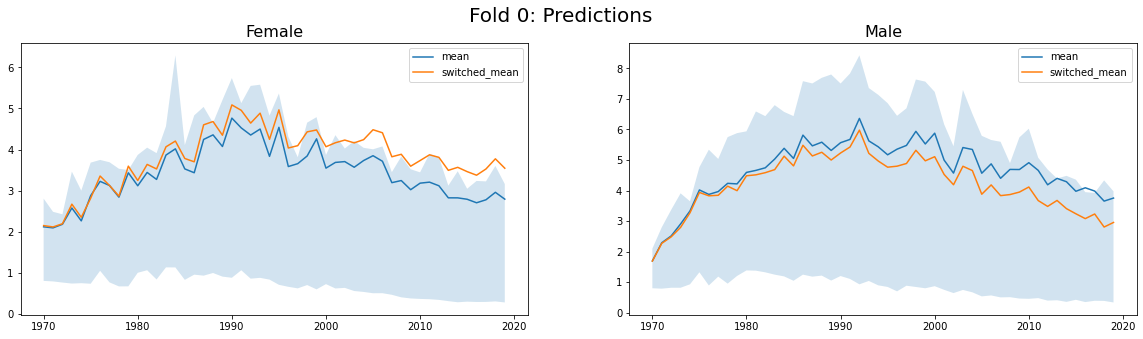

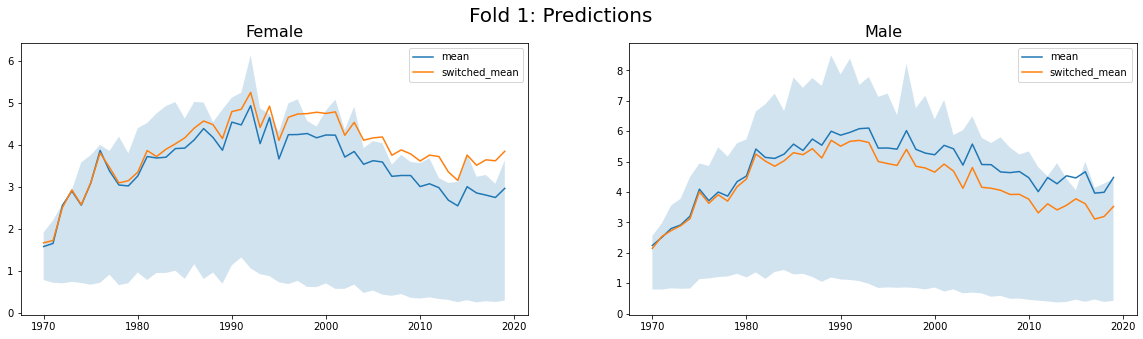

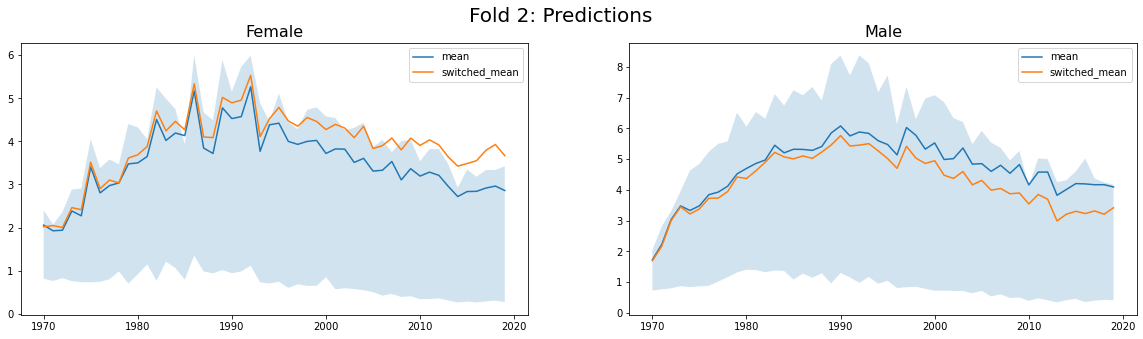

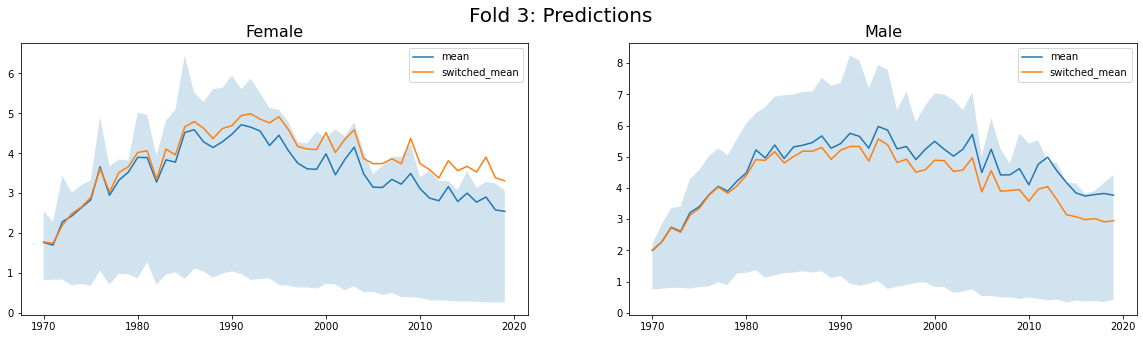

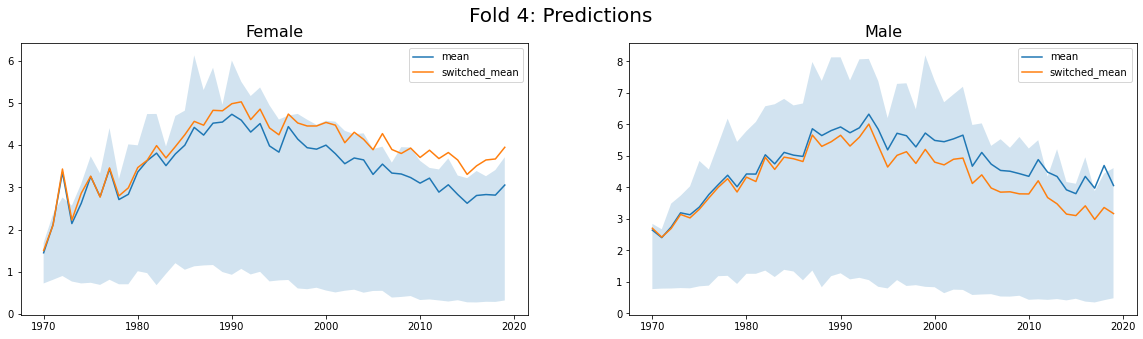

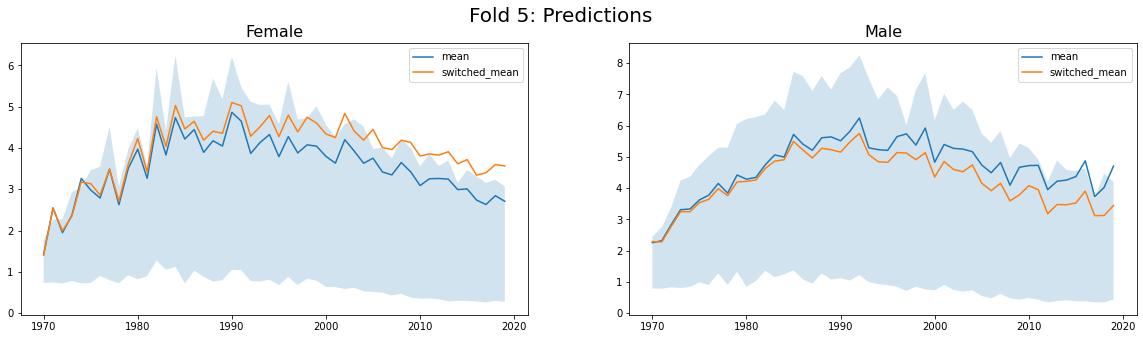

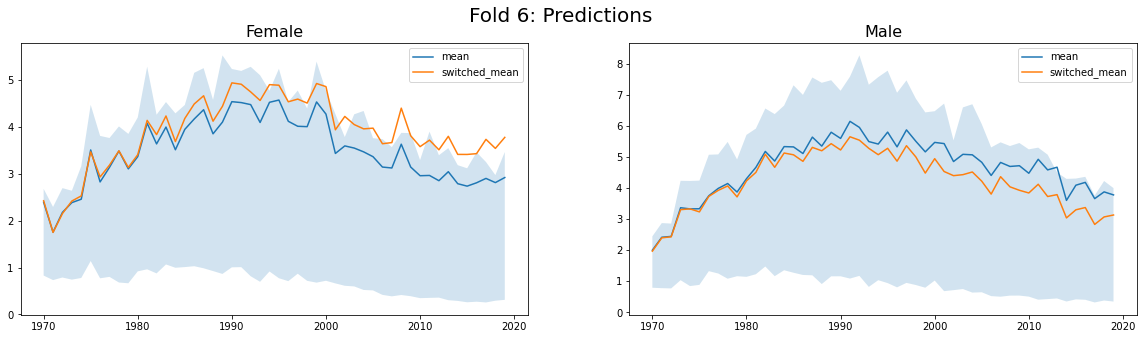

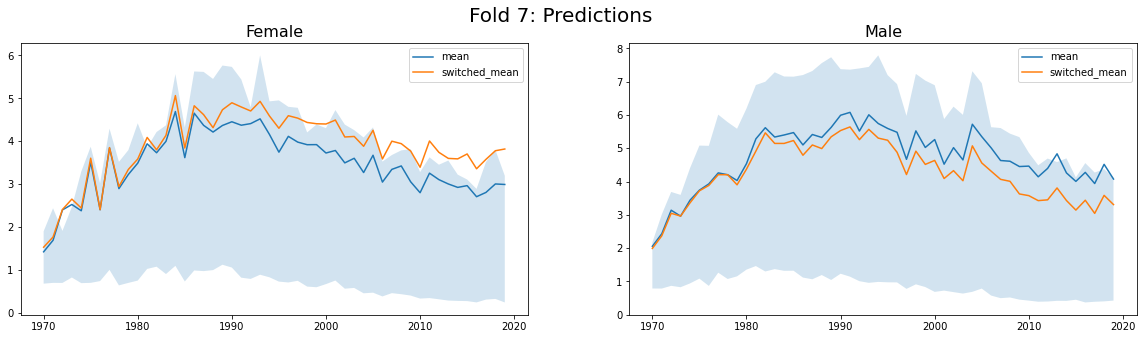

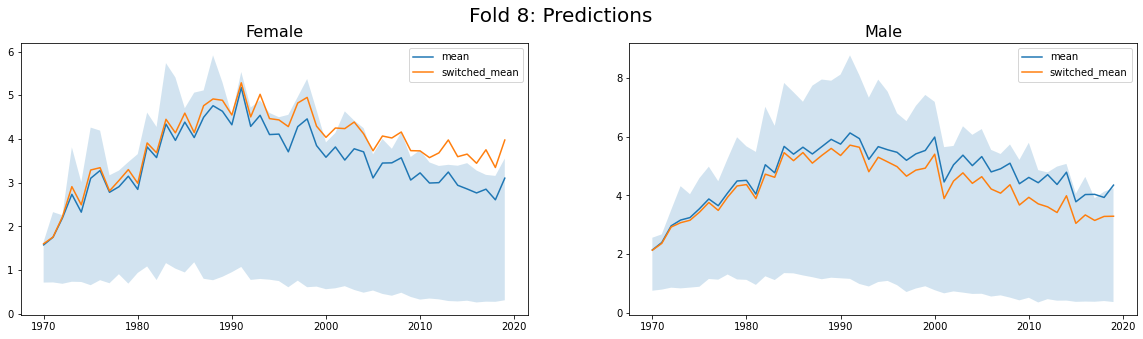

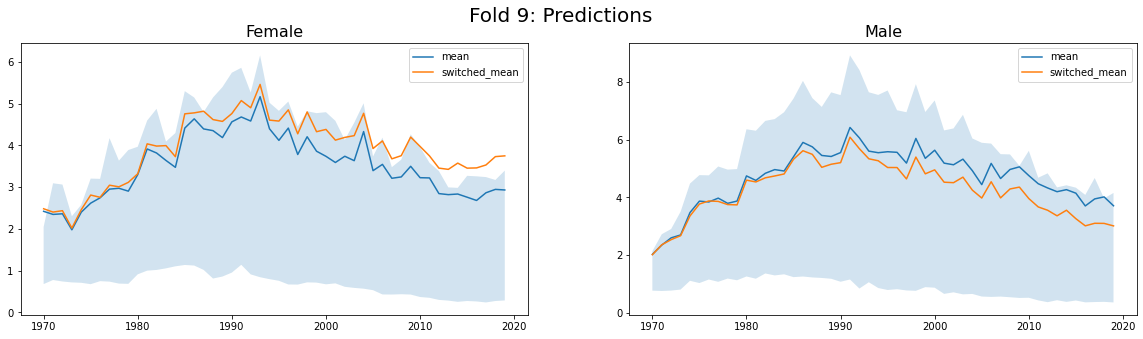

In [15]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    bias.plot_gs_results(r_test, r_switched_test, "year", "y_hat", "Fold {}: Predictions".format(i)).show()

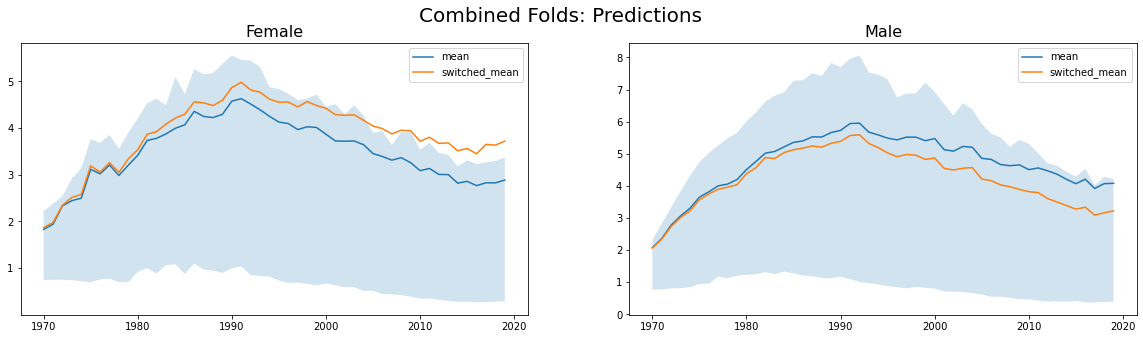

In [16]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "year", "y_hat", "Combined Folds: Predictions".format(i)).show()

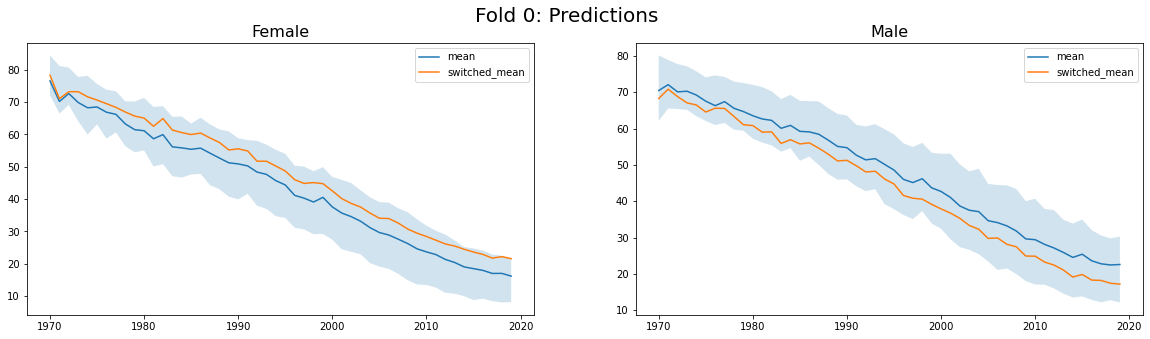

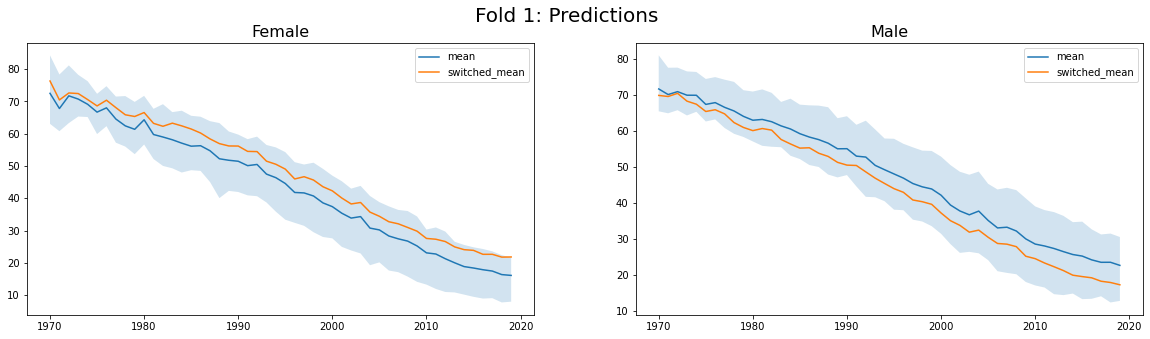

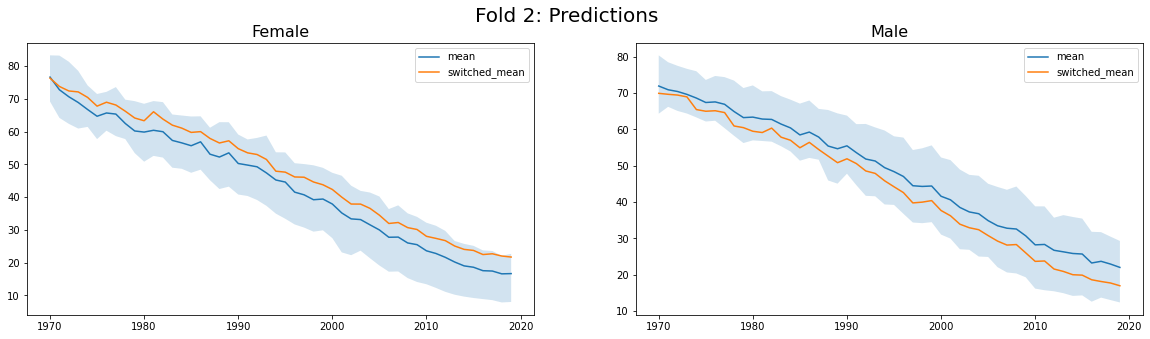

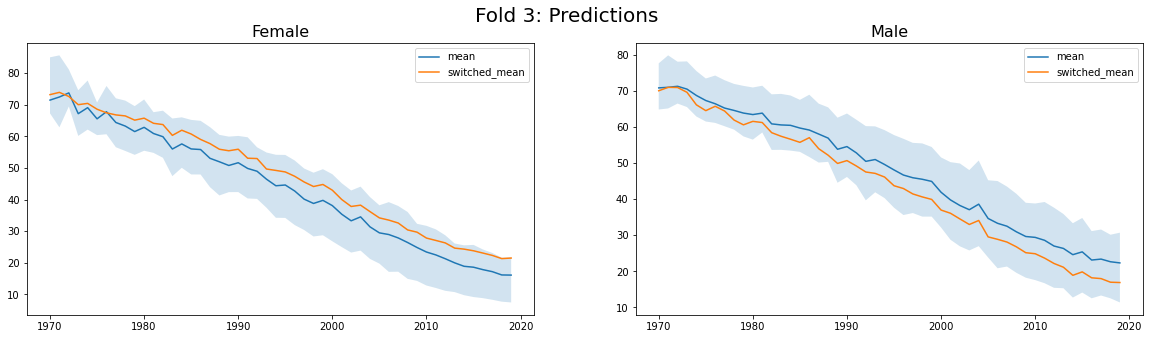

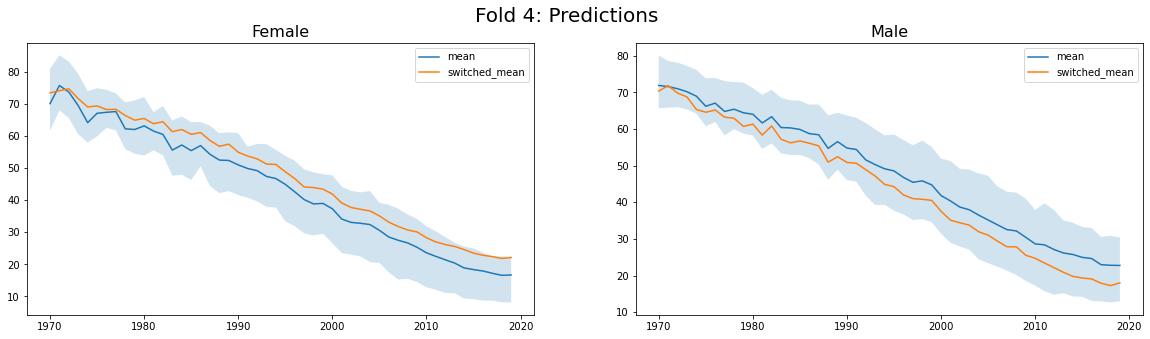

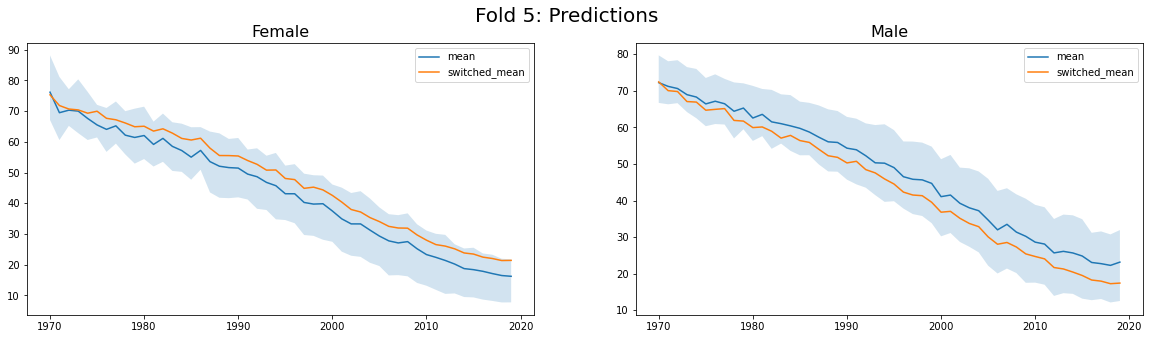

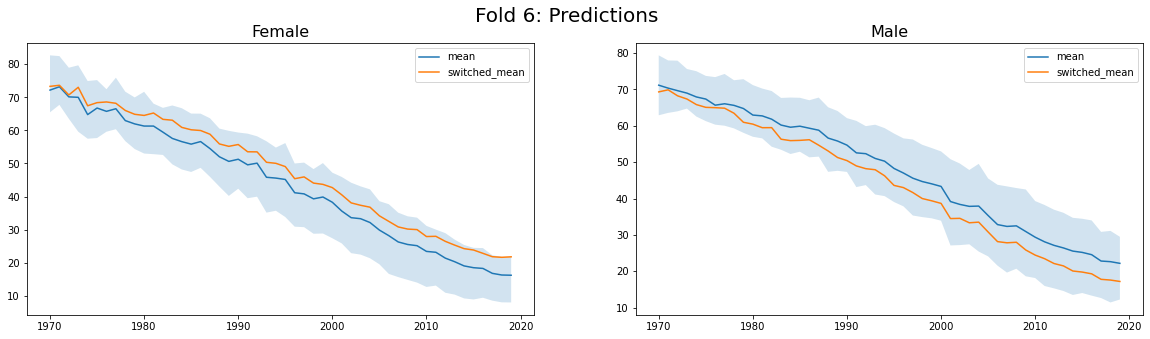

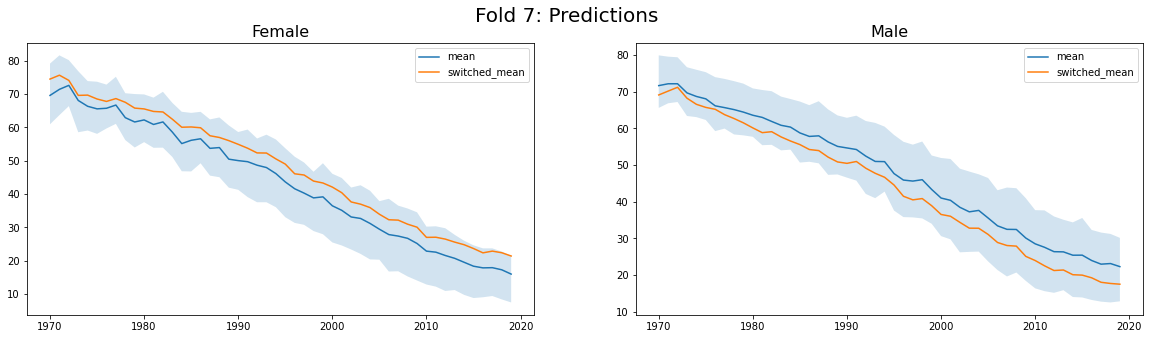

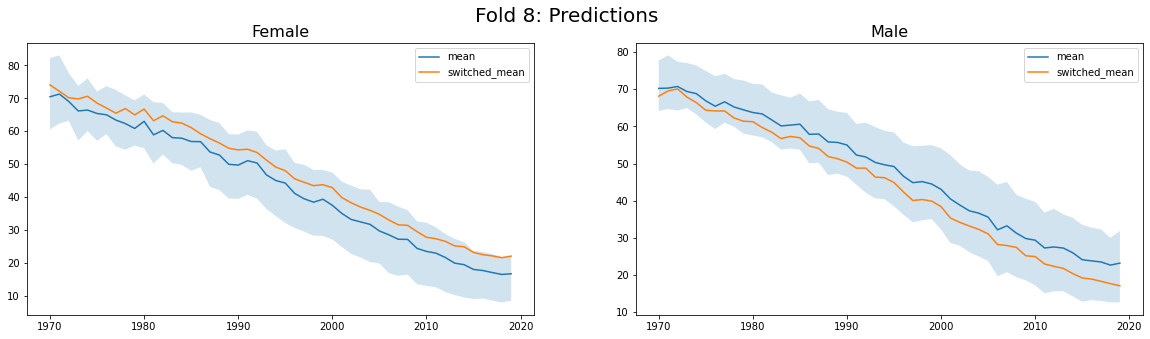

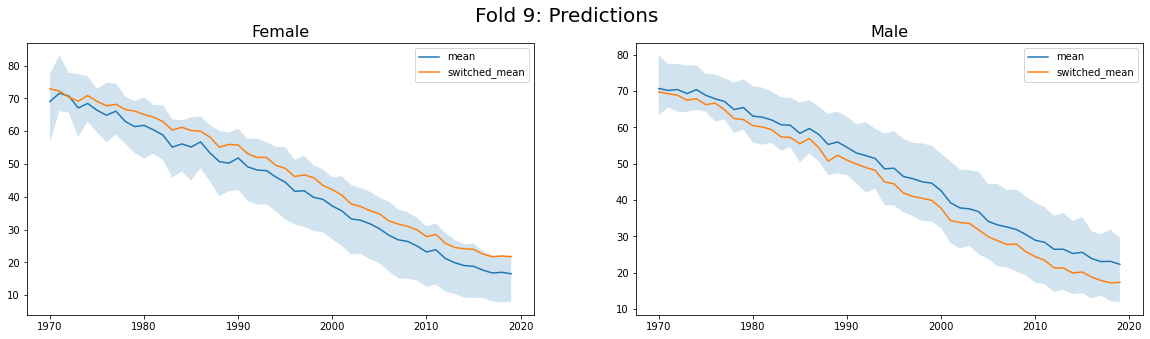

In [17]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    bias.plot_gs_results(r_test, r_switched_test, "year", "y_hat_perc", "Fold {}: Predictions".format(i)).show()

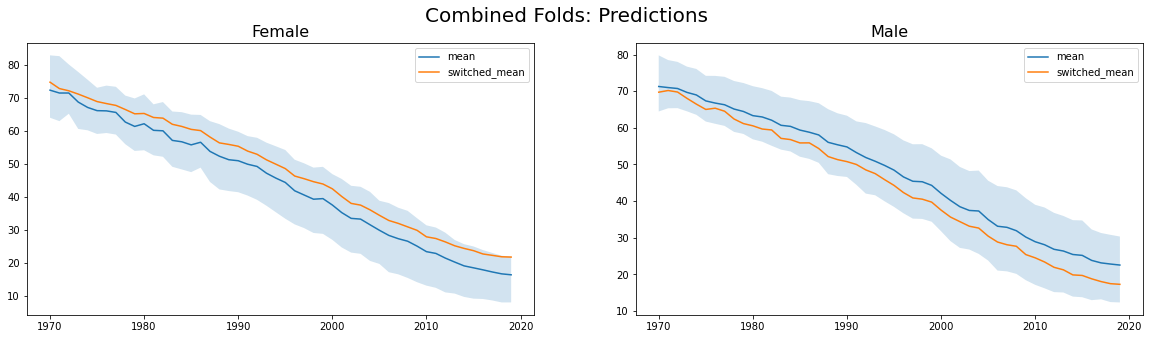

In [18]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "year", "y_hat_perc", "Combined Folds: Predictions".format(i)).show()

## Graphical distibution of predictions by author seniority

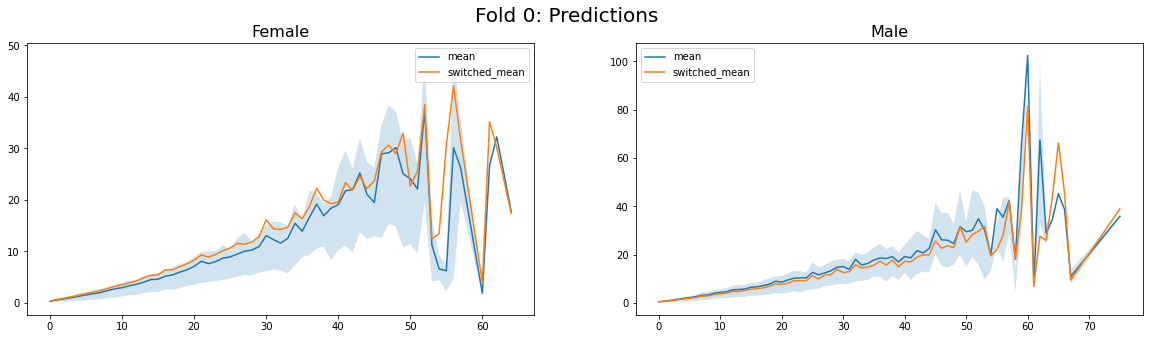

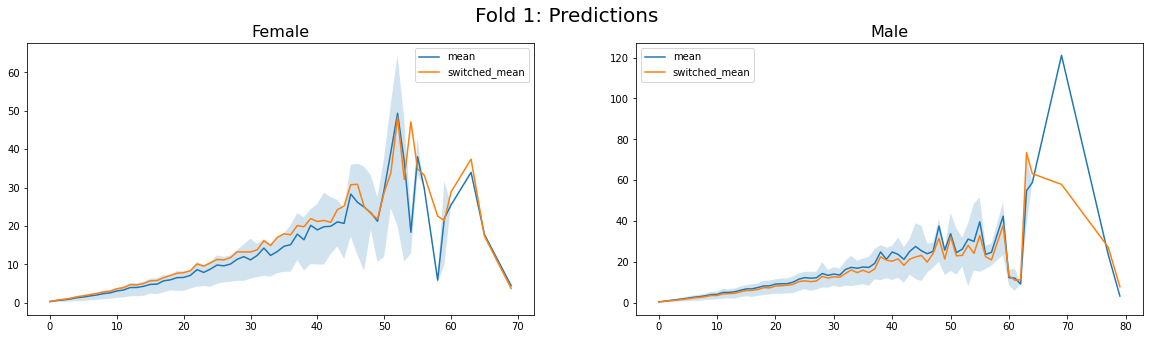

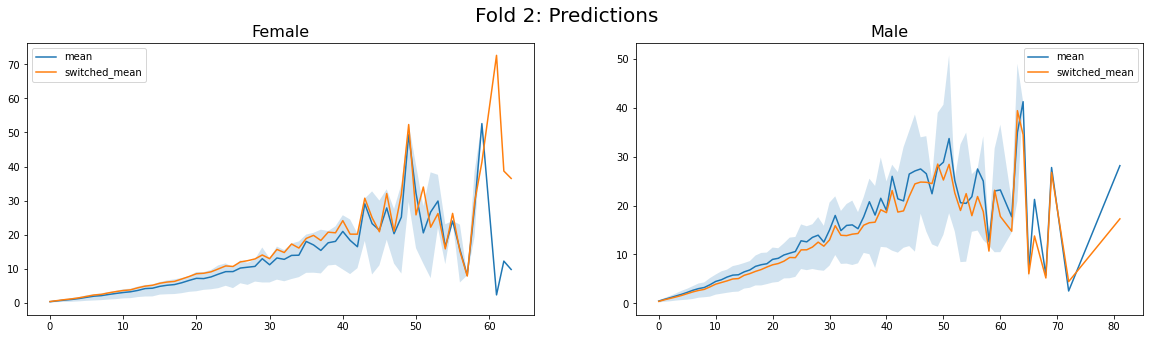

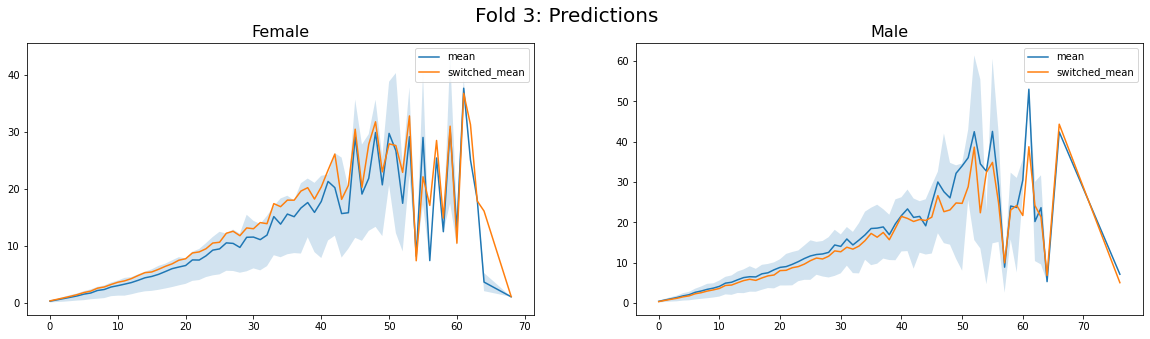

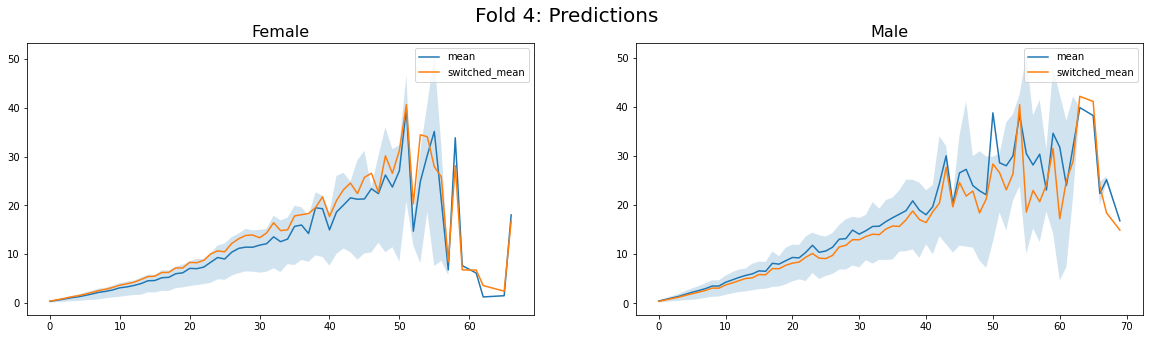

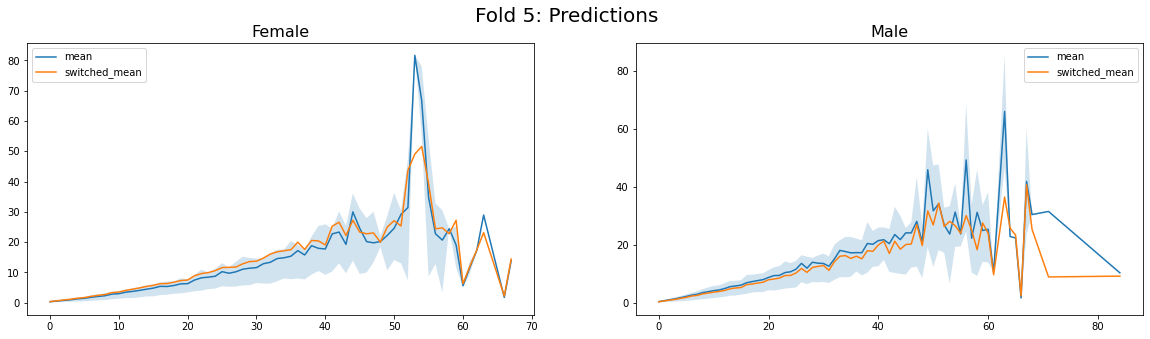

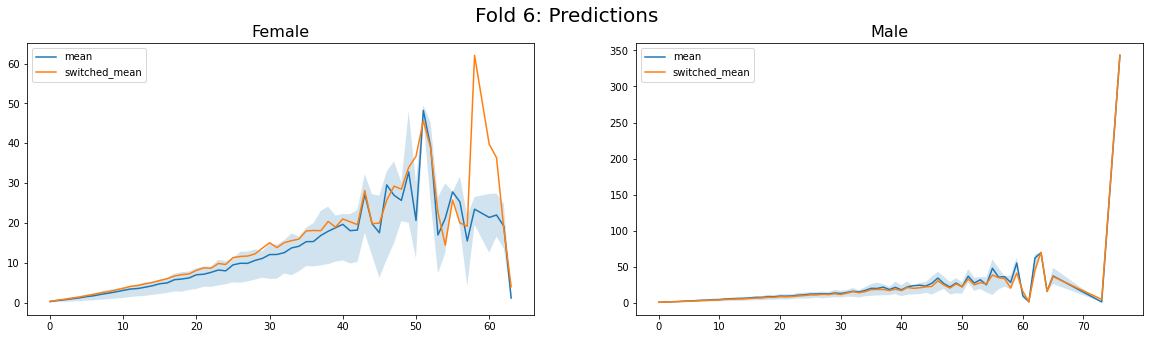

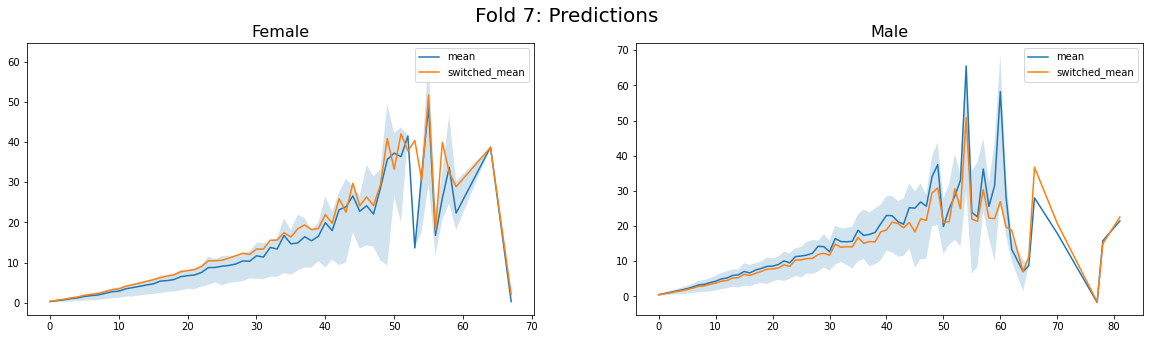

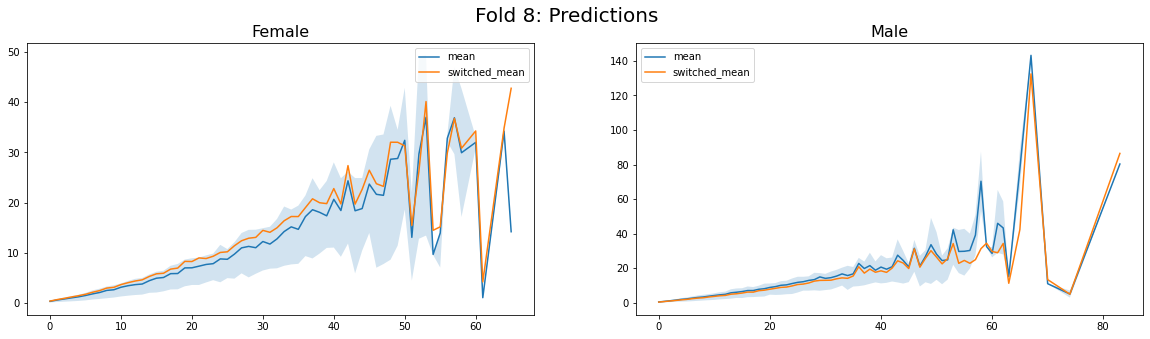

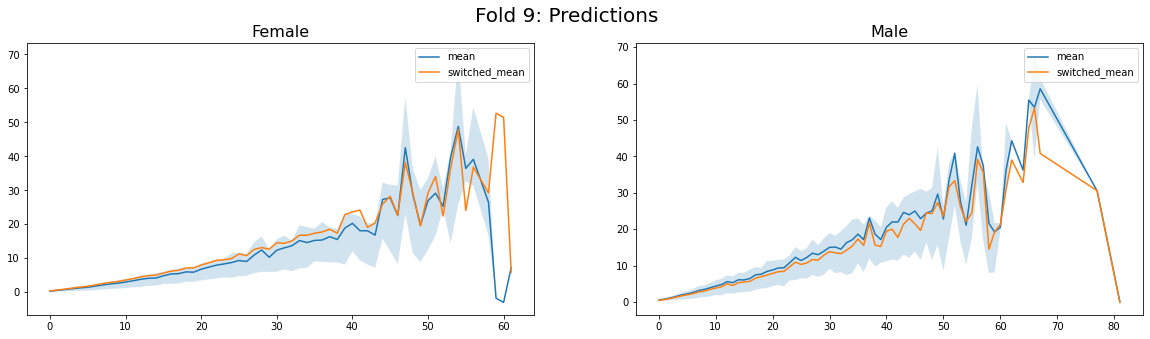

In [19]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    bias.plot_gs_results(r_test, r_switched_test, "author_seniority", "y_hat", "Fold {}: Predictions".format(i)).show()

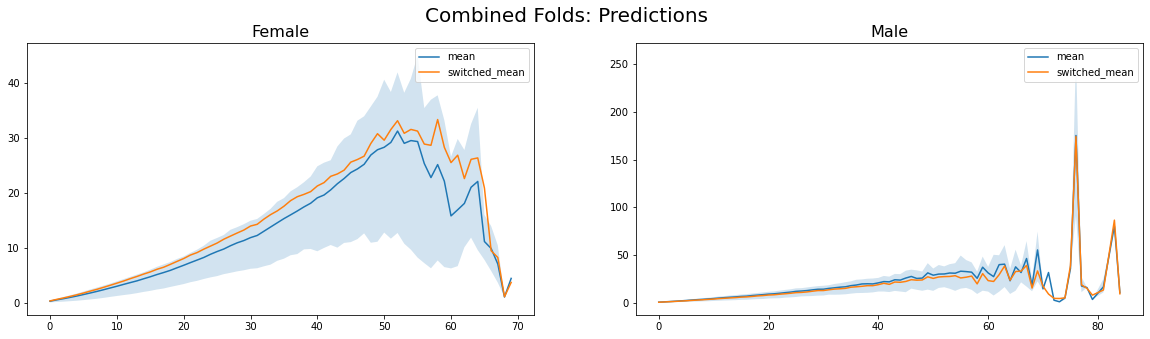

In [20]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "author_seniority", "y_hat", "Combined Folds: Predictions".format(i)).show()

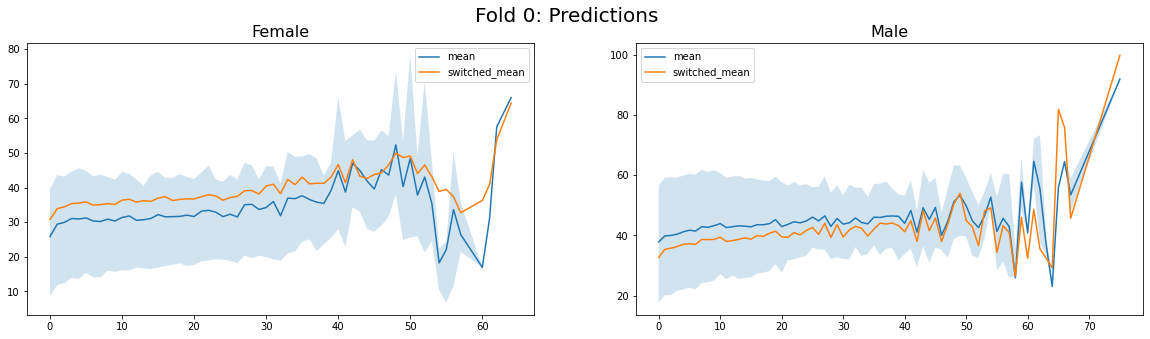

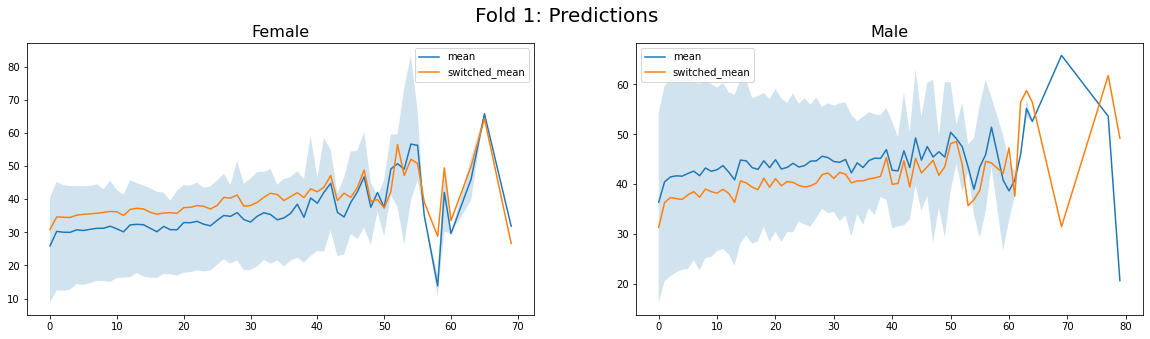

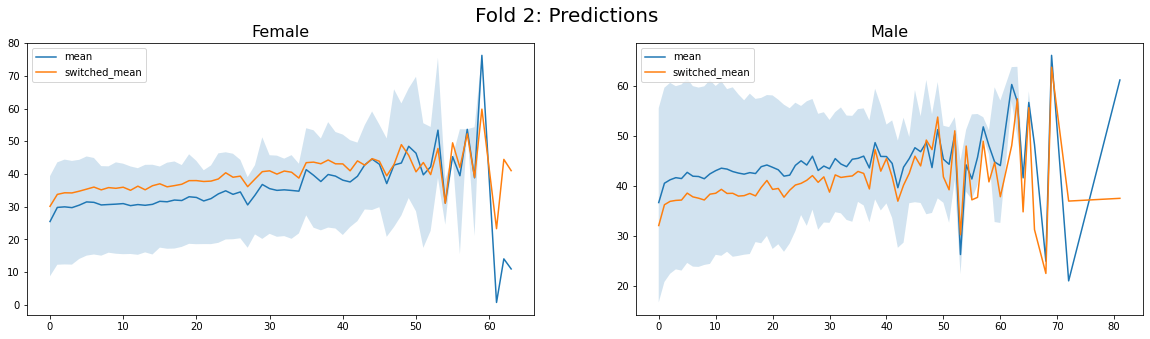

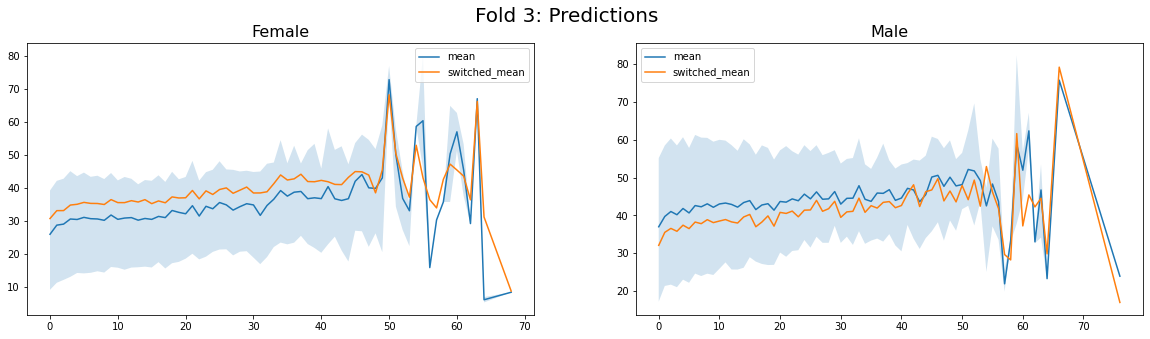

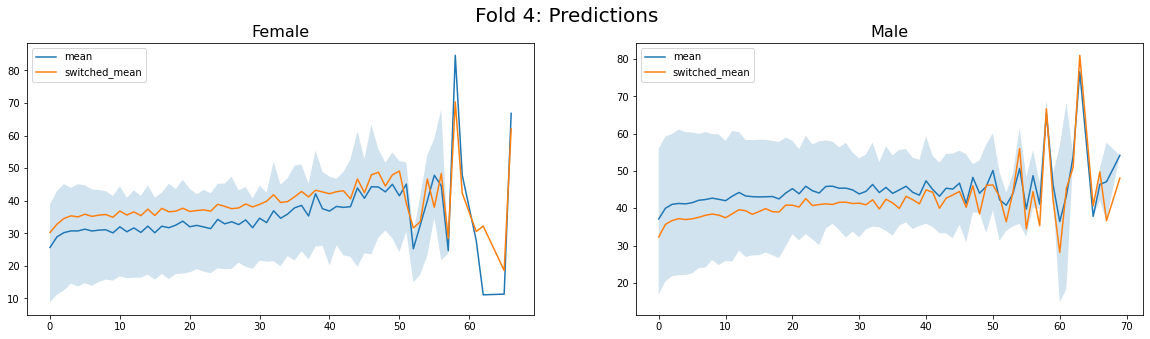

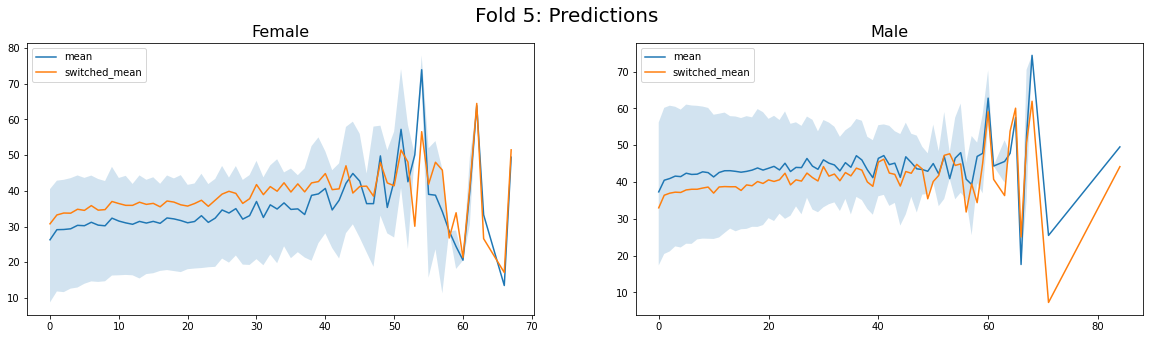

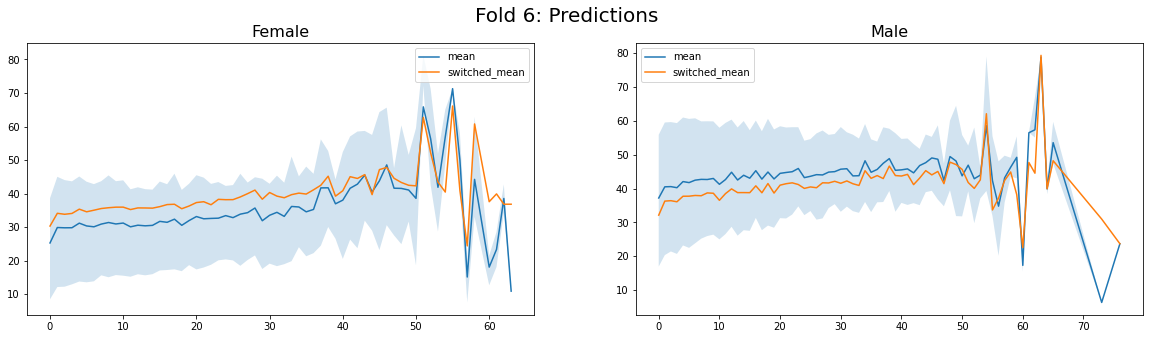

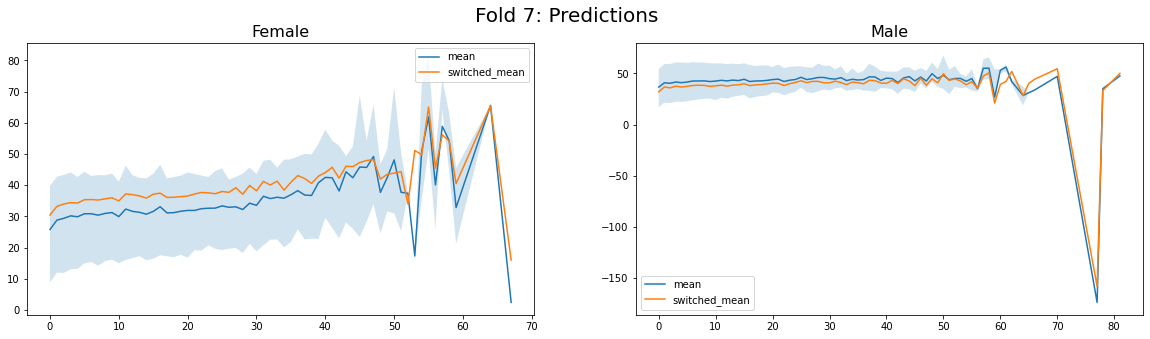

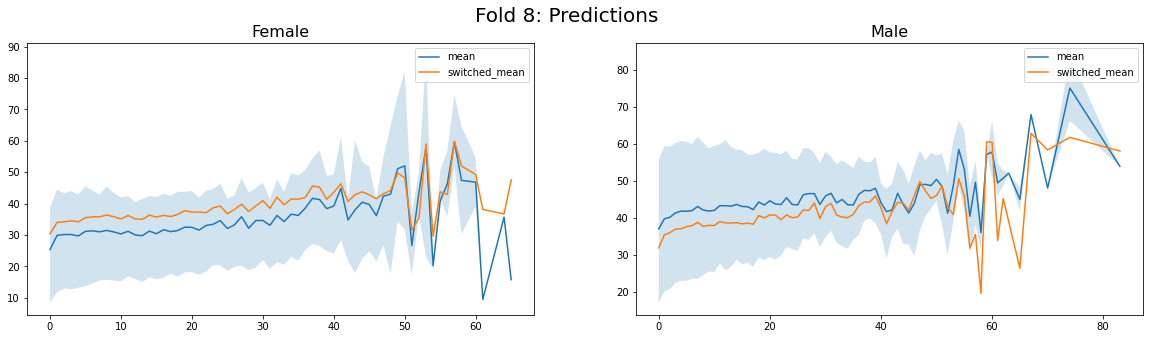

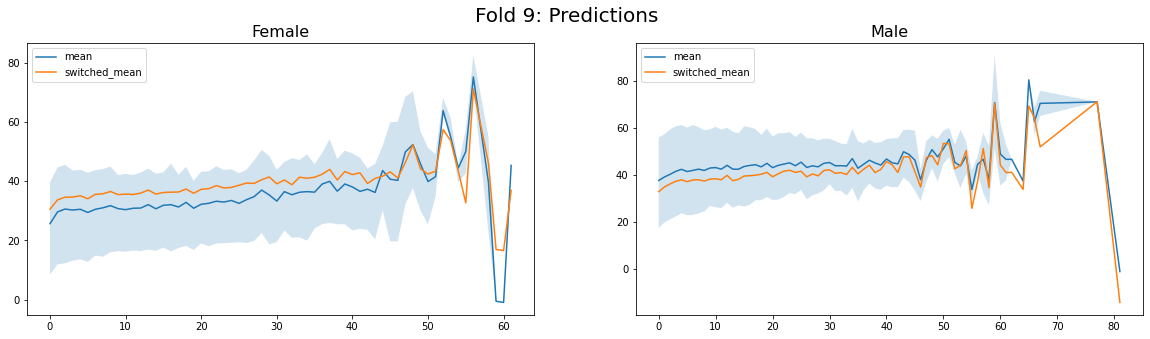

In [21]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    bias.plot_gs_results(r_test, r_switched_test, "author_seniority", "y_hat_perc", "Fold {}: Predictions".format(i)).show()

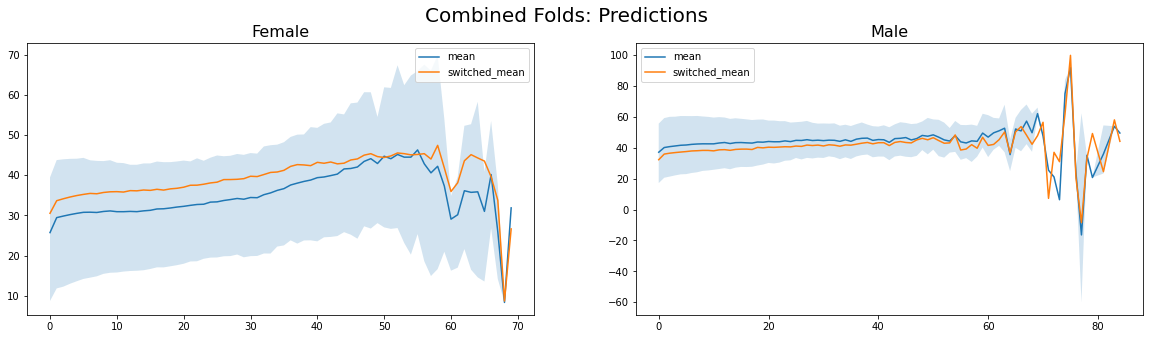

In [22]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "author_seniority", "y_hat_perc", "Combined Folds: Predictions".format(i)).show()

## Graphical distibution of predictions by clustered number of publications per author

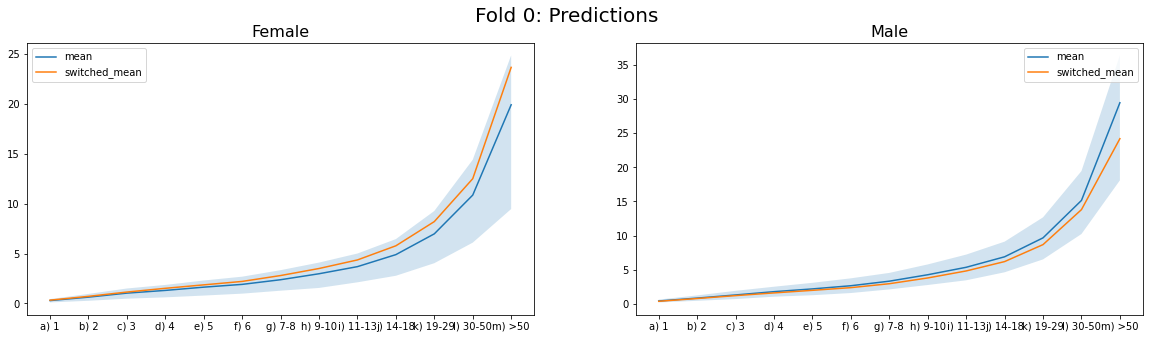

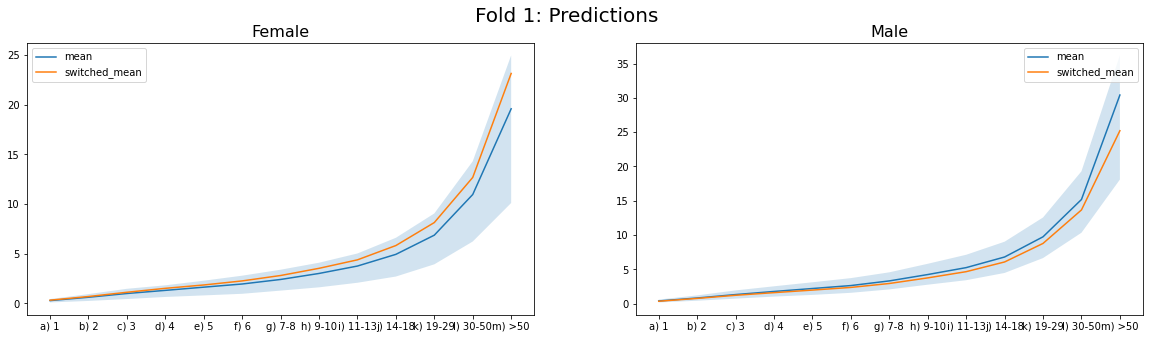

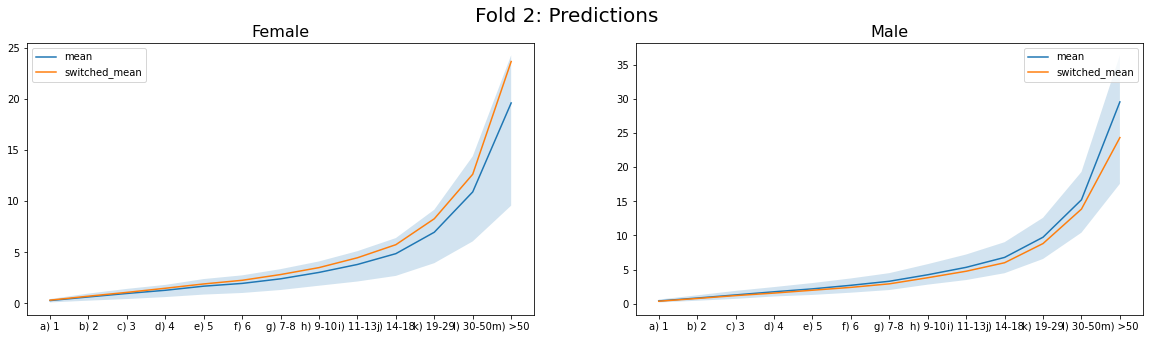

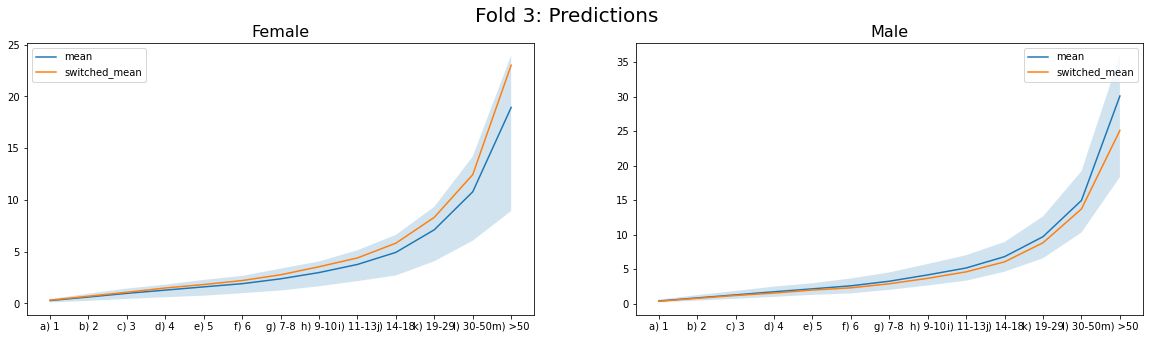

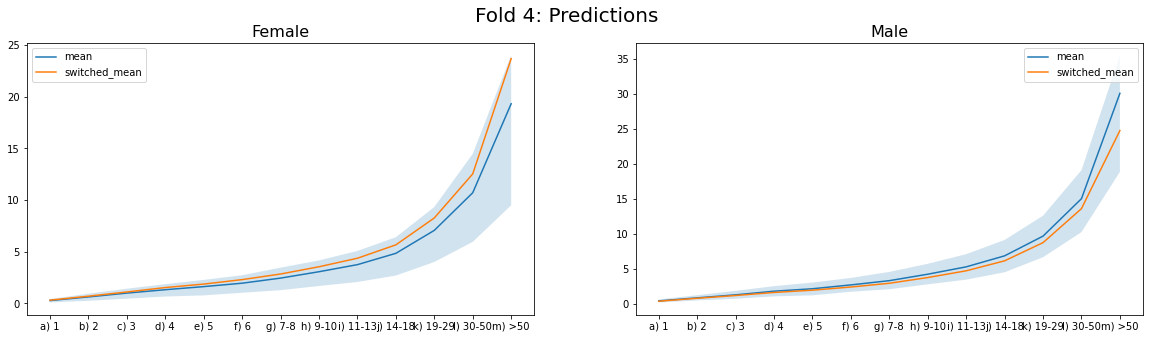

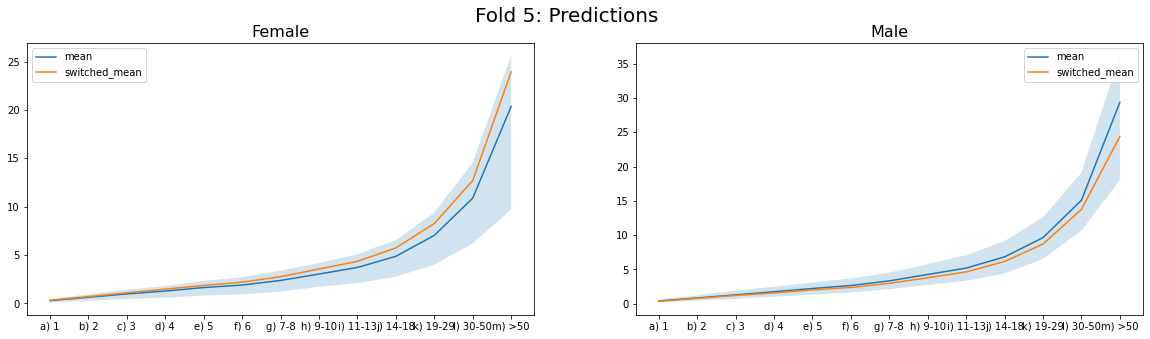

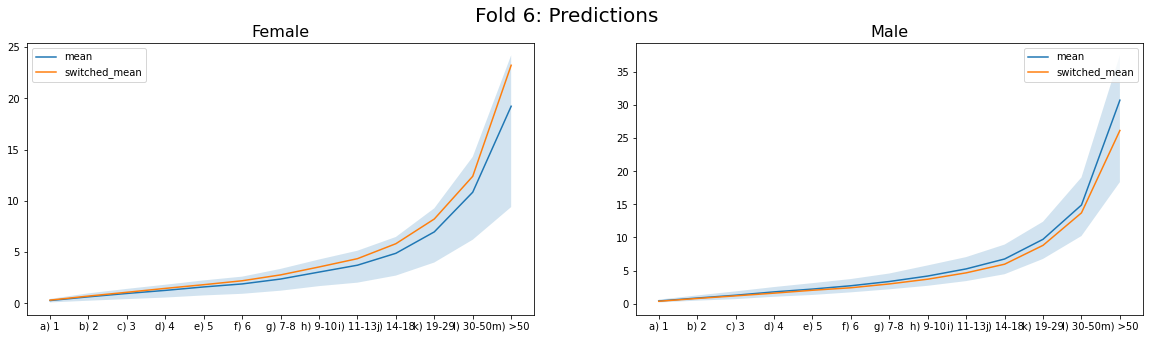

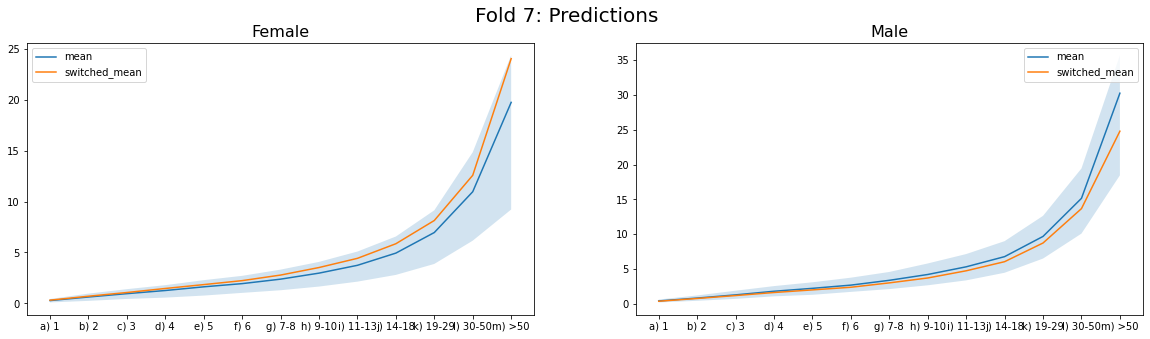

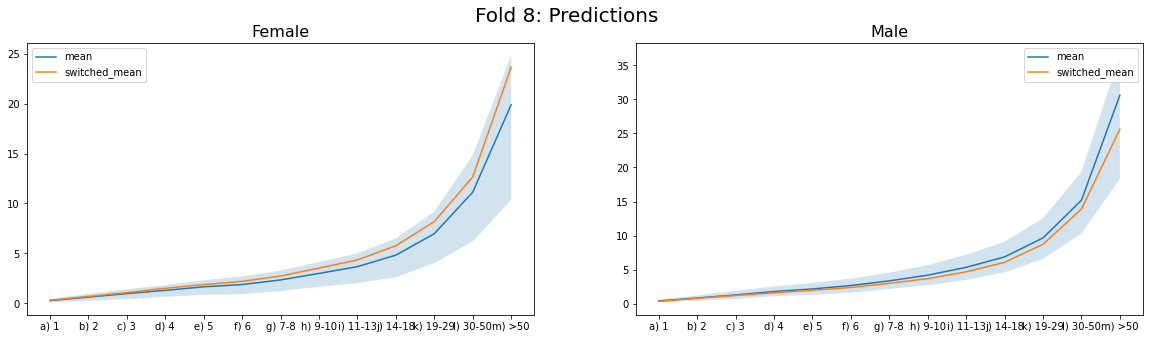

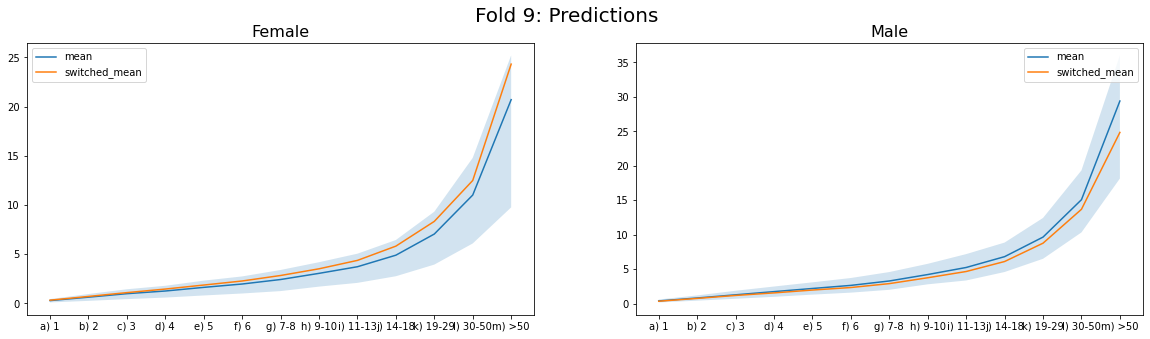

In [23]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_test = bias.cluster_column(r_test, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
    r_switched_test = switched_fold_results[i]
    r_switched_test = bias.cluster_column(r_switched_test, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
    
    bias.plot_gs_results(r_test, r_switched_test, "num_aggl_publications_cluster", "y_hat", "Fold {}: Predictions".format(i), x_categories=bias.PUBLICATION_COUNT_CLUSTERING).show()

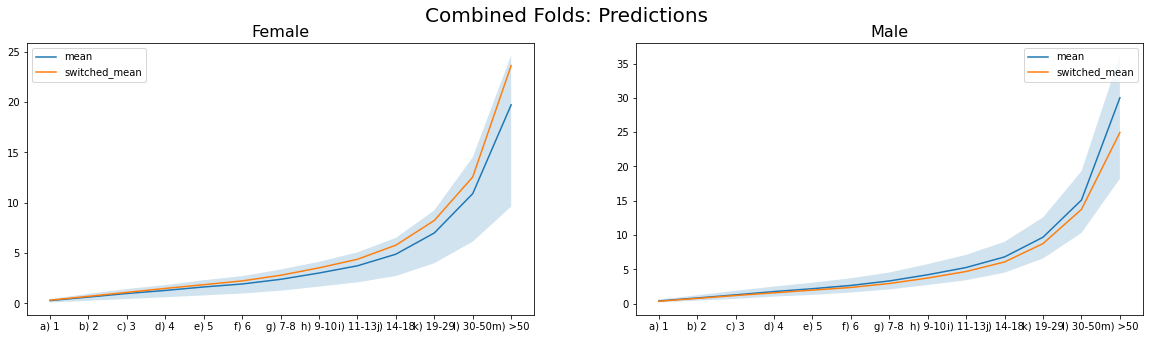

In [24]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "num_aggl_publications_cluster", "y_hat", "Combined Folds: Predictions".format(i), x_categories=bias.PUBLICATION_COUNT_CLUSTERING).show()

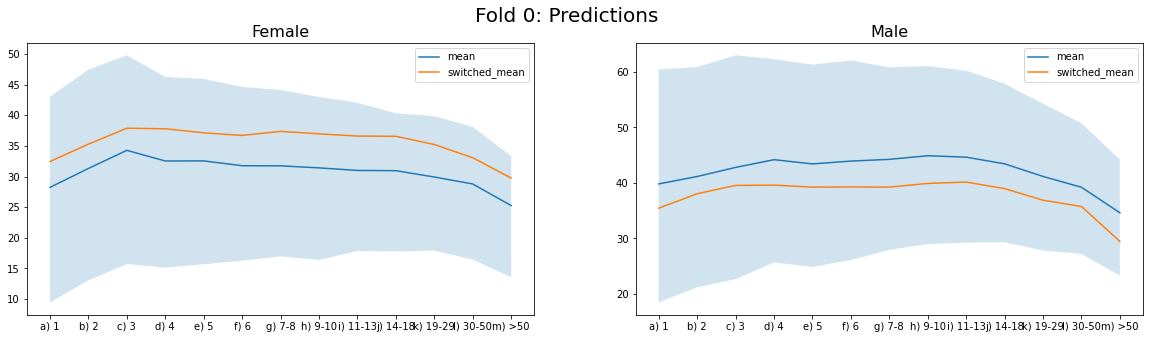

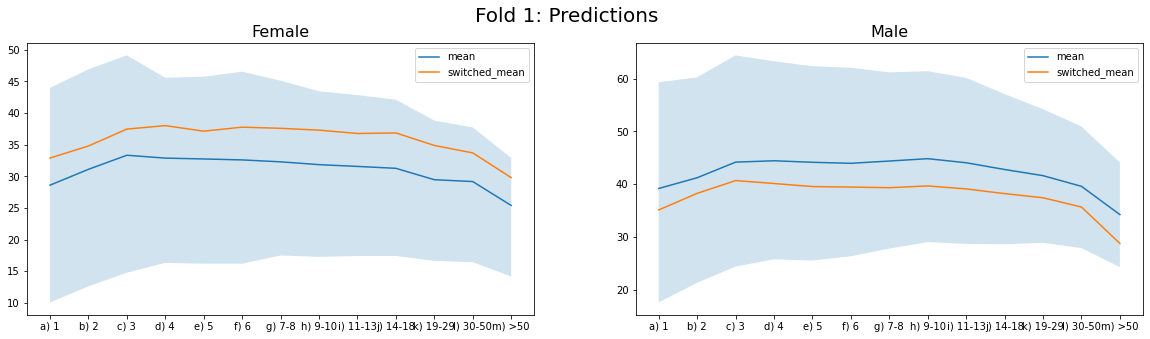

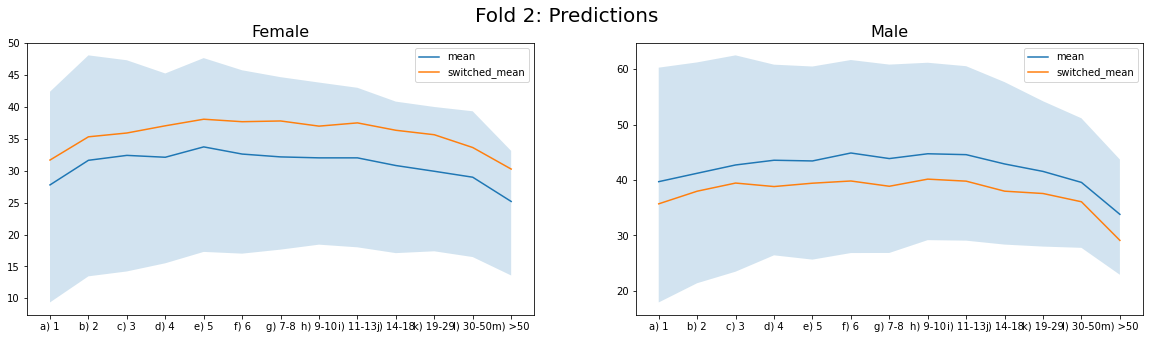

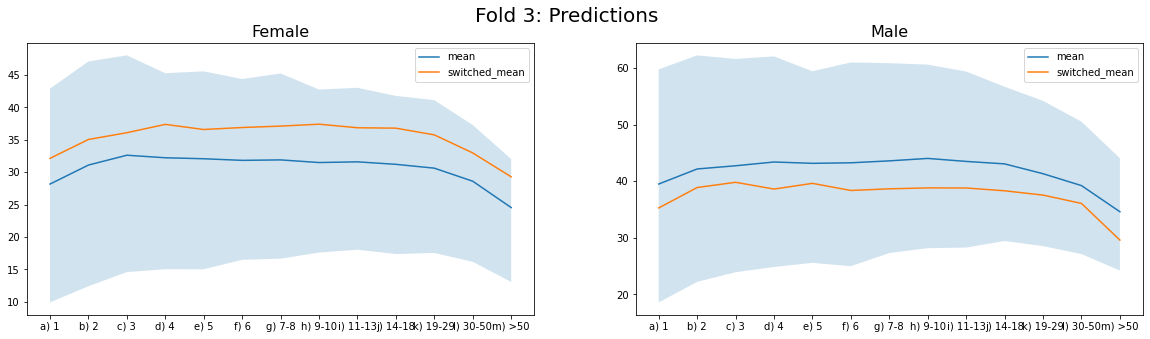

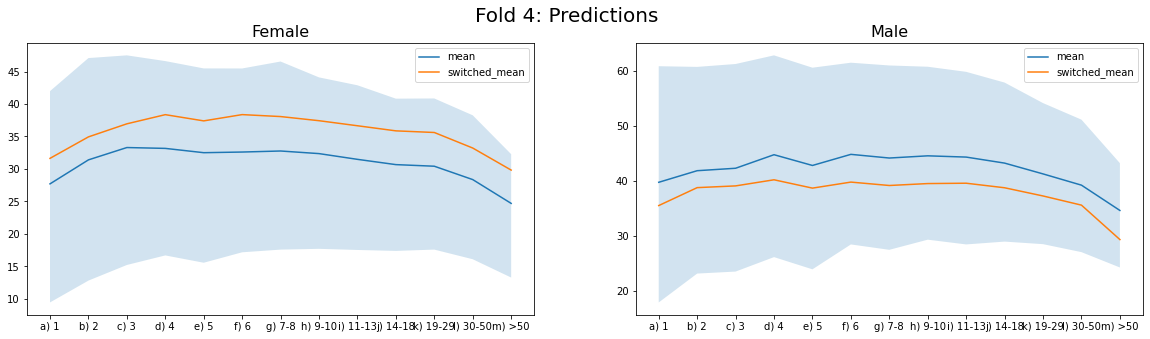

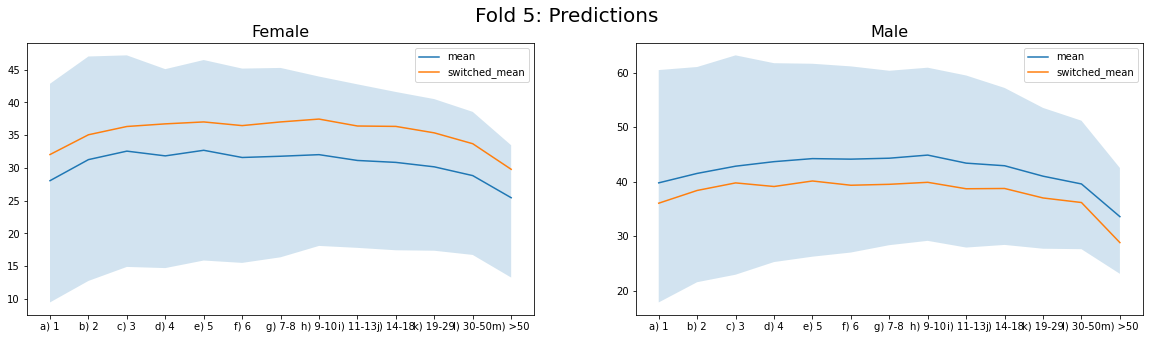

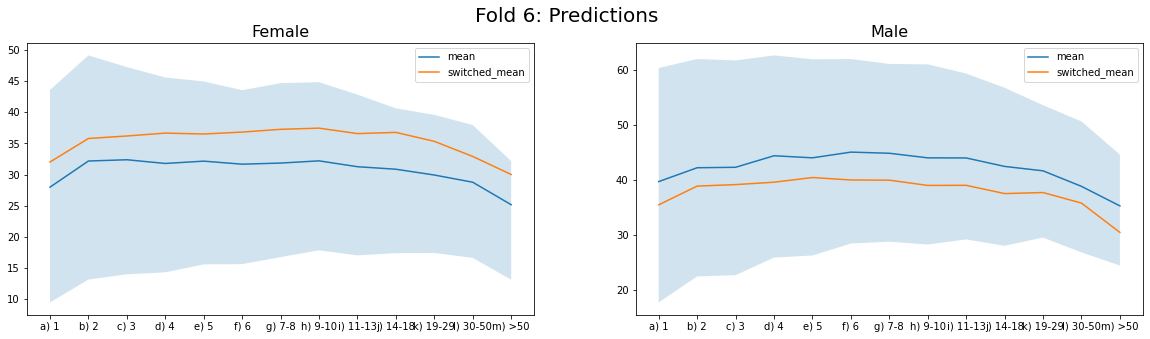

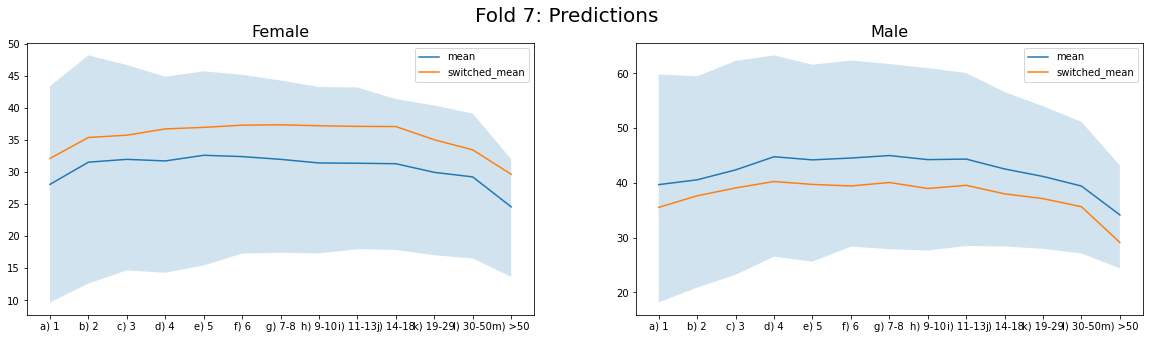

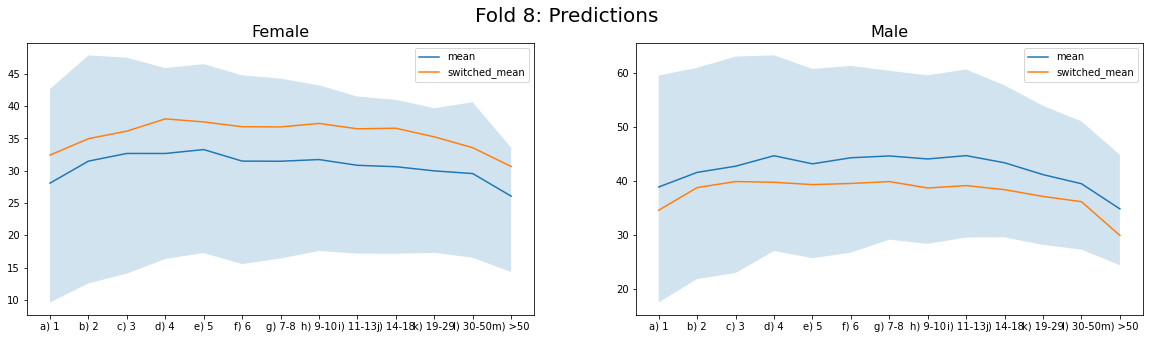

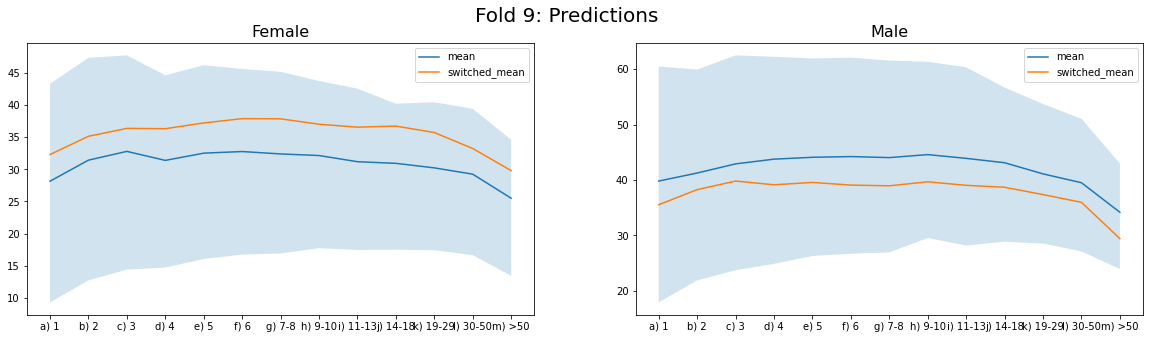

In [25]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_test = bias.cluster_column(r_test, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
    r_switched_test = switched_fold_results[i]
    r_switched_test = bias.cluster_column(r_switched_test, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
    
    bias.plot_gs_results(r_test, r_switched_test, "num_aggl_publications_cluster", "y_hat_perc", "Fold {}: Predictions".format(i), x_categories=bias.PUBLICATION_COUNT_CLUSTERING).show()

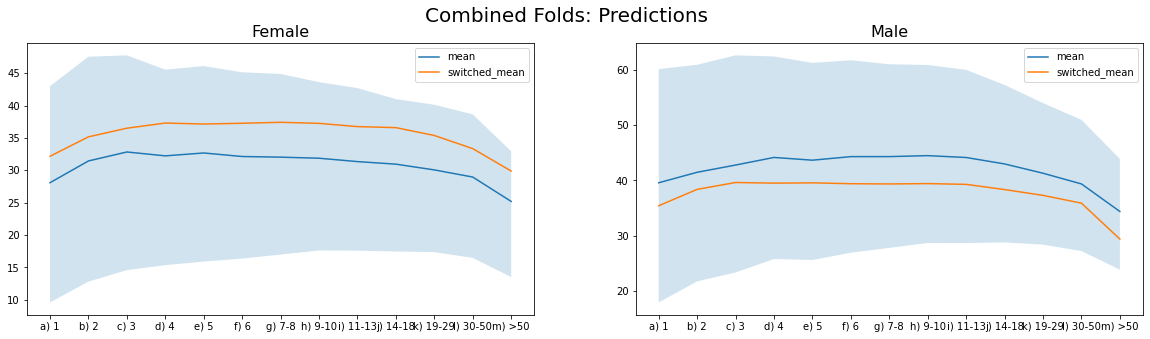

In [26]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "num_aggl_publications_cluster", "y_hat_perc", "Combined Folds: Predictions".format(i), x_categories=bias.PUBLICATION_COUNT_CLUSTERING).show()